# Linear Spectral Unmixing

Spectral unmixing assumes that the spectral response of a pixel is the linear product of a series of endmembers from which we can define the proportions associated with a pixel (i.e., unmix the mixed pixels). To do this we need to define the endmembers without our feature space, these are essentially simple training samples for a classifier but rather than taking in the full variation of the class want to just identify the ‘end member’ (i.e., the most spectrally ‘pure’ example of that class). 

## Running Notebook

The notebook has been run and saved with the outputs so you can see what the outputs should be and so the notebook and be browsed online without having to run the notebook for it to make sense. 

If you are running the notebook for yourself it is recommended that you clear the existing outputs which can be done by running one of the following options depending on what system you are using:

**Jupyter-lab**:

> \> _Edit_ \> _'Clear All Outputs'_

**Jupyter-notebook**:

> \> _Cell_ \> _'All Outputs'_ \> _Clear_



# 1. Import Modules

In [6]:
import os
import shutil

import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy
import rsgislib.imagecalc
import rsgislib.imagecalc.calcindices
import rsgislib.imagecalc.specunmixing
import rsgislib.imageutils
import rsgislib.rastergis
import rsgislib.tools.mapping
import rsgislib.tools.plotting
import rsgislib.tools.utils
import rsgislib.vectorutils
import rsgislib.vectorutils.createvectors
import rsgislib.zonalstats

# Import the matplotlib plotting module and set it to work within
# a notebook environment.
%matplotlib inline

# 2. Define Input Files and Output Directory

In [2]:
input_ref_img = "../data/hymap_injune_subset.kea"
input_img = "hymap_injune_subset.kea"
shutil.copy(input_ref_img, input_img)

out_dir = "spec_unmix_out_dir"
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

# Read the HyMap metadata for wavelength info.
hymap_meta_file = "../data/hymap_wavelengths.json"
hymap_metadata = rsgislib.tools.utils.read_json_to_dict(hymap_meta_file)

# 3. Defining Endmembers

## 3.1 Plotting Feature Space

It is useful to plot the feature space as endmembers are often found on the edges of the feature space to undertaking what values are on the edges of the feature space can allow you to look at your imagery and interpret features which might be candidate endmembers.




Image Data Size: 100 x 100


Text(0, 0.5, 'Red Refl. (%)')

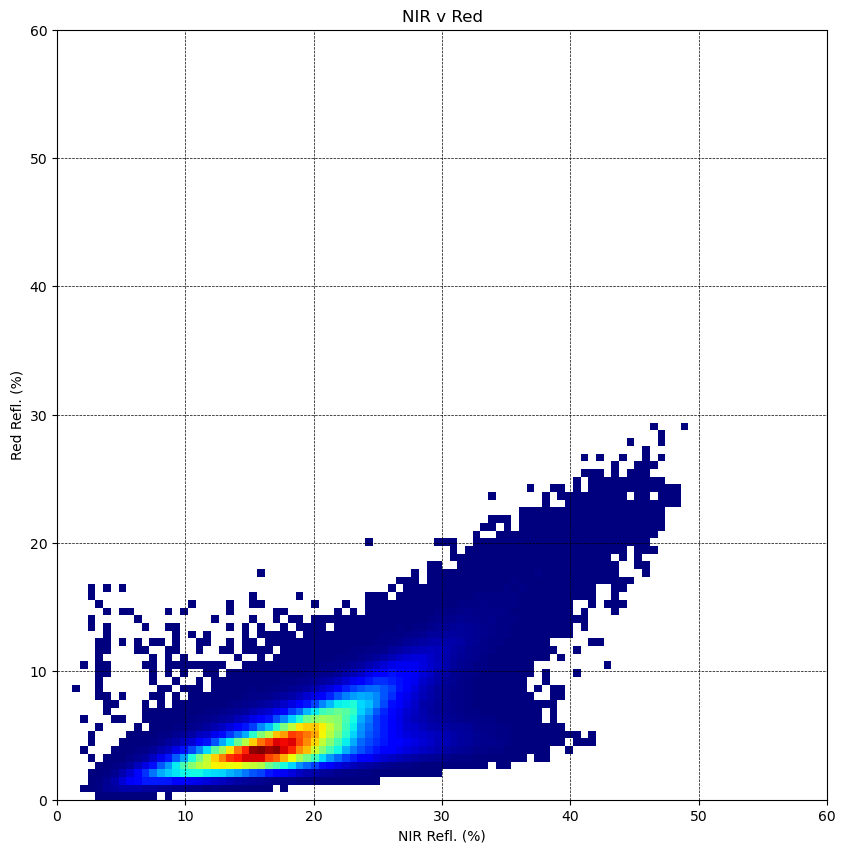

In [3]:
# Plot of NIR v Red
nir_red_histo_tmp_img = os.path.join(out_dir, "nir_red_histo_tmp_img.kea")
(
    out_bin_size_band_a,
    out_bin_size_band_b,
    r_sq,
) = rsgislib.imagecalc.get_2d_img_histogram(
    input_img,
    input_img,
    nir_red_histo_tmp_img,
    "KEA",
    img_a_band=13,
    img_b_band=42,
    n_bins=100,
    img_a_min=1,
    img_a_max=6000,
    img_b_min=1,
    img_b_max=6000,
    img_a_scale=1,
    img_b_scale=1,
    img_a_offset=0,
    img_b_offset=0,
    normalise=True,
)

nir_red_histo_data, img_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    nir_red_histo_tmp_img, bands=[1]
)

# Create the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 10))

cmap = plt.get_cmap("jet")
mcolors.Colormap.set_under(cmap, color="white")
mcolors.Colormap.set_over(cmap, color="white")

min_val = numpy.min(nir_red_histo_data[nir_red_histo_data != 0])
max_val = numpy.max(nir_red_histo_data)
c_norm = mcolors.Normalize(vmin=min_val, vmax=max_val)

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax.imshow(
    nir_red_histo_data,
    cmap=cmap,
    aspect="equal",
    norm=c_norm,
    origin="lower",
    extent=[0, 60, 0, 60],
)
ax.grid(color="k", linestyle="--", linewidth=0.5)

plt.title("NIR v Red")
plt.xlabel("NIR Refl. (%)")
plt.ylabel("Red Refl. (%)")



Image Data Size: 100 x 100


Text(0, 0.5, 'SWIR Refl. (%)')

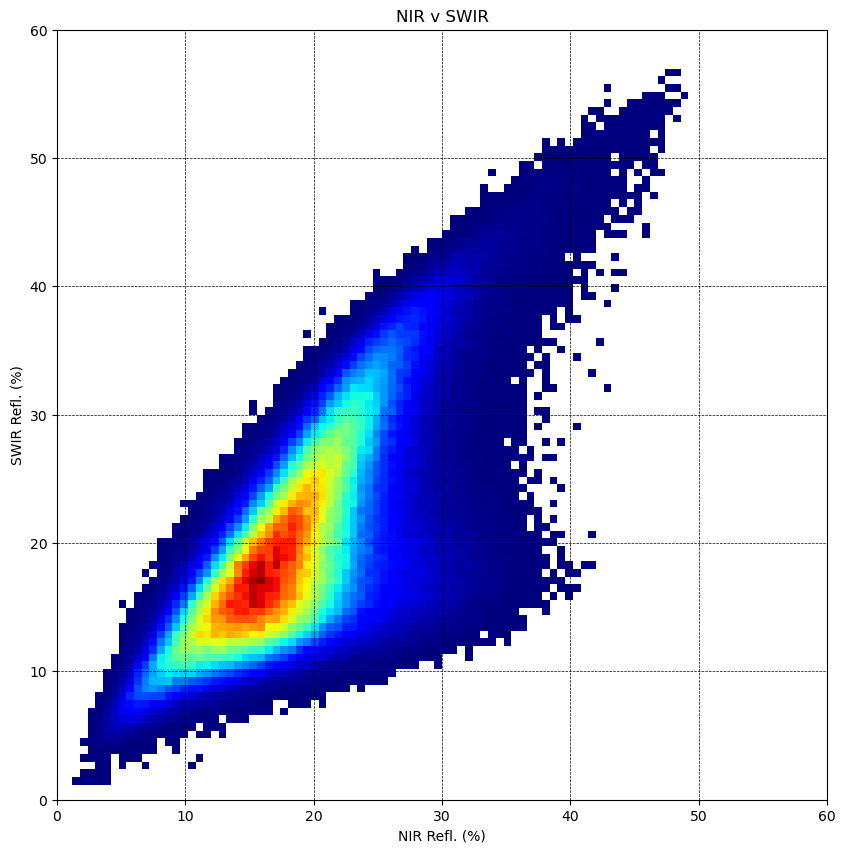

In [7]:
# Plot of NIR v SWIR
nir_swir_histo_tmp_img = os.path.join(out_dir, "nir_swir_histo_tmp_img.kea")
(
    out_bin_size_band_a,
    out_bin_size_band_b,
    r_sq,
) = rsgislib.imagecalc.get_2d_img_histogram(
    input_img,
    input_img,
    nir_swir_histo_tmp_img,
    "KEA",
    img_a_band=81,
    img_b_band=42,
    n_bins=100,
    img_a_min=1,
    img_a_max=6000,
    img_b_min=1,
    img_b_max=6000,
    img_a_scale=1,
    img_b_scale=1,
    img_a_offset=0,
    img_b_offset=0,
    normalise=True,
)

nir_swir_histo_data, img_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    nir_swir_histo_tmp_img, bands=[1]
)

# Create the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 10))

cmap = plt.get_cmap("jet")
mcolors.Colormap.set_under(cmap, color="white")
mcolors.Colormap.set_over(cmap, color="white")

min_val = numpy.min(nir_swir_histo_data[nir_swir_histo_data != 0])
max_val = numpy.max(nir_swir_histo_data)
c_norm = mcolors.Normalize(vmin=min_val, vmax=max_val)

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax.imshow(
    nir_swir_histo_data,
    cmap=cmap,
    aspect="equal",
    norm=c_norm,
    origin="lower",
    extent=[0, 60, 0, 60],
)
ax.grid(color="k", linestyle="--", linewidth=0.5)

plt.title("NIR v SWIR")
plt.xlabel("NIR Refl. (%)")
plt.ylabel("SWIR Refl. (%)")



Image Data Size: 100 x 100


Text(0, 0.5, 'Green Refl. (%)')

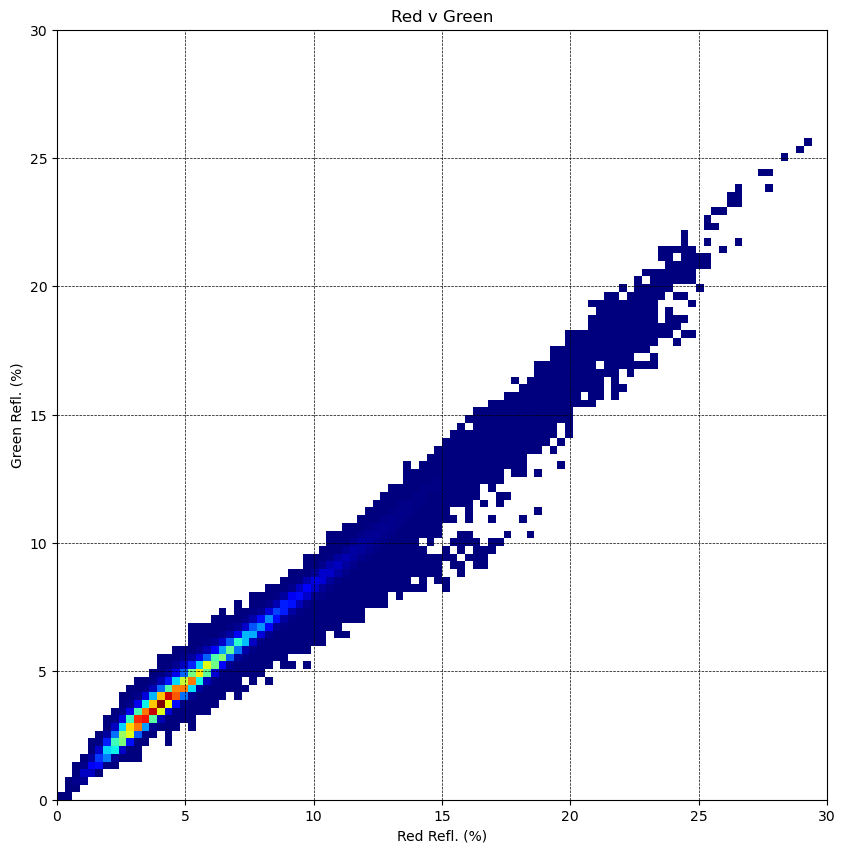

In [5]:
# Plot of Red v Green
red_green_histo_tmp_img = os.path.join(out_dir, "red_green_histo_tmp_img.kea")
(
    out_bin_size_band_a,
    out_bin_size_band_b,
    r_sq,
) = rsgislib.imagecalc.get_2d_img_histogram(
    input_img,
    input_img,
    red_green_histo_tmp_img,
    "KEA",
    img_a_band=9,
    img_b_band=13,
    n_bins=100,
    img_a_min=1,
    img_a_max=3000,
    img_b_min=1,
    img_b_max=3000,
    img_a_scale=1,
    img_b_scale=1,
    img_a_offset=0,
    img_b_offset=0,
    normalise=True,
)

red_green_histo_data, img_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    red_green_histo_tmp_img, bands=[1]
)

# Create the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 10))

cmap = plt.get_cmap("jet")
mcolors.Colormap.set_under(cmap, color="white")
mcolors.Colormap.set_over(cmap, color="white")

min_val = numpy.min(red_green_histo_data[red_green_histo_data != 0])
max_val = numpy.max(red_green_histo_data)
c_norm = mcolors.Normalize(vmin=min_val, vmax=max_val)

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax.imshow(
    red_green_histo_data,
    cmap=cmap,
    aspect="equal",
    norm=c_norm,
    origin="lower",
    extent=[0, 30, 0, 30],
)
ax.grid(color="k", linestyle="--", linewidth=0.5)

plt.title("Red v Green")
plt.xlabel("Red Refl. (%)")
plt.ylabel("Green Refl. (%)")

## 3.2 Manually Defined Endmembers

Often, end members are defined by manually by annotating the image through user interpretation of the scene. An example is given below where the coordinates of pixels for the following classes have been identified:

 1. Photosynthetic Vegetation
 2. Soil / bare ground
 3. Shadow


*You may wish to edit these locations and compare these spectra with those derived from the spectrally smoothed HyMap image.*


In [8]:
# Coordinates of endmember pixels (identified in QGIS):
# 0: Photosynthetic pixel
# 1: Soil / bare ground pixel
# 2: Shadow pixel
x_coords = numpy.array([546933.6, 547573.3, 547903.6])
y_coords = numpy.array([7165115.7, 7164588.9, 7161428.6])

# Get the image pixel coordinates for those pixels:
x_pxl_coords, y_pxl_coords = rsgislib.imageutils.get_img_pxl_coords(input_img, x_coords, y_coords)
print(x_pxl_coords)
print(y_pxl_coords)

[143 389 517]
[ 697  900 2116]


In [9]:
# Get the image pixel values for endmembers
photo_pxl_vals = rsgislib.imageutils.get_img_pxl_column(
    input_img, x_pxl_coord=x_pxl_coords[0], y_pxl_coord=y_pxl_coords[0]
)
bare_pxl_vals = rsgislib.imageutils.get_img_pxl_column(
    input_img, x_pxl_coord=x_pxl_coords[1], y_pxl_coord=y_pxl_coords[1]
)
shadow_pxl_vals = rsgislib.imageutils.get_img_pxl_column(
    input_img, x_pxl_coord=x_pxl_coords[2], y_pxl_coord=y_pxl_coords[2]
)

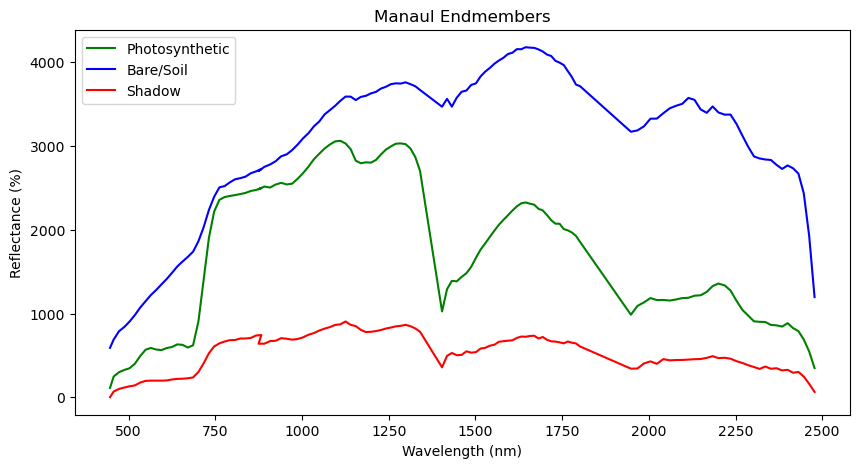

In [10]:
# Plot Endmembers
# Create the matplotlib figure
fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))

ax1.plot(
    hymap_metadata["wavelength"], photo_pxl_vals, label="Photosynthetic", color="green"
)
ax1.plot(hymap_metadata["wavelength"], bare_pxl_vals, label="Bare/Soil", color="blue")
ax1.plot(hymap_metadata["wavelength"], shadow_pxl_vals, label="Shadow", color="red")
ax1.set_title("Manaul Endmembers")
ax1.set_ylabel("Reflectance (%)")
ax1.set_xlabel("Wavelength (nm)")
ax1.legend()

Image Data Size: 628 x 2702


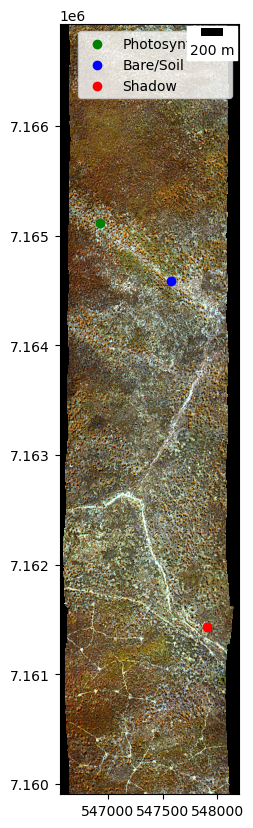

In [12]:
# Plot the Endmember locations on a map
# Create the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 10))

# Plot original Image
# Visualise with bands 32 (NIR), 19 (Red Edge) and 1 (Blue)
rsgislib.tools.mapping.create_raster_img_map(
    ax,
    input_img,
    img_bands=[32, 19, 1],
    img_stch=rsgislib.IMG_STRECTH_CUMULATIVE,
    show_scale_bar=True,
)

ax.scatter(x_coords[0], y_coords[0], label="Photosynthetic", color="green")
ax.scatter(x_coords[1], y_coords[1], label="Bare/Soil", color="blue")
ax.scatter(x_coords[2], y_coords[2], label="Shadow", color="red")
ax.legend()

## 3.3 Pixel Purity Index (PPI)

There is a large literature of methods to find endmembers within imagery, in terms of spectral unmixing it is the largest area of active research. One of the simplest approaches in ‘pixel purity index’ (PPI) which aims to identify pixels in the image which are thought to be ‘pure’ from which you can then draw a set of end members, as done above.

PPI is an iterative method which randomly rotates the axes of the data and counting the number of times a pixel is found 'on the edge' of the feature space. The output image contains this count and therefore would need thresholding to identified defined regions.

The most common way of running a PPI analysis with hyperspectral data is to use the output from a MNF, in this case we will use the MNF regions subset to the top 5 components. Reducing the number of dimensions (i.e., bands) significantly speeds up the calculation of the PPI. 

This analysis is run below and will first normalise the 5 MNF components so they all have a range between 1-100, with 0 being the no data value. 



In [13]:
# Calculate the MNF result
mnf_img = os.path.join(out_dir, "hymap_injune_subset_mnf.kea")

tmp_mnf_dir = "mnf_tmp"
if not os.path.exists(tmp_mnf_dir):
    os.mkdir(tmp_mnf_dir)

# As we know from the PCA we only need 5 components.
rsgislib.imagecalc.perform_image_mnf(
    input_img,
    mnf_img,
    n_comps=5,
    pxl_n_sample=100,
    in_img_no_data=0,
    tmp_dir=tmp_mnf_dir,
    gdalformat="KEA",
    datatype=rsgislib.TYPE_16INT,
    calc_stats=True,
)

# Normalise the MNF results
mnf_norm_img = os.path.join(out_dir, "hymap_injune_subset_mnf_norm.kea")
rsgislib.imageutils.normalise_img_pxl_vals(
    input_img=mnf_img,
    output_img=mnf_norm_img,
    gdalformat="KEA",
    datatype=rsgislib.TYPE_32FLOAT,
    in_no_data_val=0,
    out_no_data_val=0,
    out_min=1,
    out_max=100,
    stretch_type=rsgislib.imageutils.STRETCH_LINEARMINMAX,
    stretch_param=1,
)
rsgislib.imageutils.pop_img_stats(
    mnf_norm_img, use_no_data=True, no_data_val=0, calc_pyramids=True
)

0) hymap_injune_subset.kea
New image width = 628 height = 2702 bands = 1

Importing Bands:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:07<00:00, 16.34it/s]


Create empty output image file

Output Bands:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:10<00:00,  5.48it/s]


15396 values were extracted from the input image.
Prop. of variance explained:
	 PCA Component 1 = 0.8219
	 PCA Component 2 = 0.1542
	 PCA Component 3 = 0.0119
	 PCA Component 4 = 0.0071
	 PCA Component 5 = 0.0023
	 PCA Component 6 = 0.0006
	 PCA Component 7 = 0.0005
	 PCA Component 8 = 0.0003
	 PCA Component 9 = 0.0002
	 PCA Component 10 = 0.0002
	 PCA Component 11 = 1e-04
	 PCA Component 12 = 1e-04
	 PCA Component 13 = 1e-04
	 PCA Component 14 = 1e-04
	 PCA Component 15 = 0.0
	 PCA Component 16 = 0.0
	 PCA Component 17 = 0.0
	 PCA Component 18 = 0.0
	 PCA Component 19 = 0.0
	 PCA Component 20 = 0.0
	 PCA Component 21 = 0.0
	 PCA Component 22 = 0.0
	 PCA Component 23 = 0.0
	 PCA Component 24 = 0.0
	 PCA Component 25 = 0.0
	 PCA Component 26 = 0.0
	 PCA Component 27 = 0.0
	 PCA Component 28 = 0.0
	 PCA Component 29 = 0.0
	 PCA Component 30 = 0.0
	 PCA Component 31 = 0.0
	 PCA Component 32 = 0.0
	 PCA Component 33 = 0.0
	 PCA Component 34 = 0.0
	 PCA Component 35 = 0.0
	 PCA Component 3

In [14]:
ppi_img = os.path.join(out_dir, "hymap_injune_subset_mnf_norm_ppi.kea")
rsgislib.imagecalc.specunmixing.calc_ppi(
    mnf_norm_img,
    ppi_img,
    gdalformat="KEA",
    niters=1000,
    lthres=1,
    uthres=2,
    img_gain=1,
    seed=None,
    calc_stats=True,
)

Importing Bands:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.85it/s]


Create empty output image file

Perform PPI iterations.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:43<00:00, 22.91it/s]


Calculate Image stats and pyramids.


Calculating Image Pyramids.



Image Data Size: 162 x 166
Image Data Size: 162 x 166


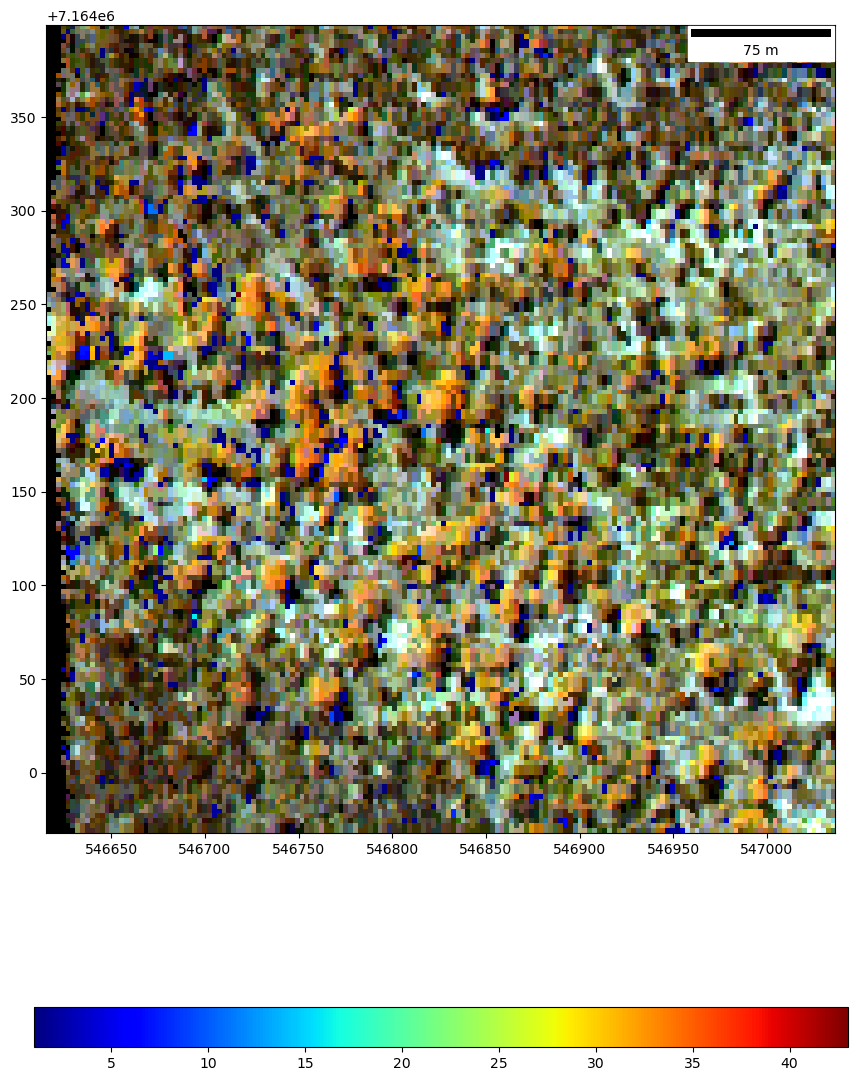

In [19]:
sub_bbox = [546614, 547036, 7163968, 7164398]


# Visualise PPI - need to zoom in to region for it to be visible
img_ppi_data, img_ppi_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    ppi_img, bands=[1], bbox=sub_bbox
)

cmap = plt.get_cmap("jet")
mcolors.Colormap.set_under(cmap, color=(1, 1, 1, 0))
mcolors.Colormap.set_over(cmap, color=(1, 1, 1, 0))

c_norm = mcolors.Normalize(vmin=1, vmax=numpy.max(img_ppi_data))

# Create the matplotlib figure
fig, ax1 = plt.subplots(1, 1, figsize=(15, 15))

# Plot original Image
# Visualise with bands 32 (NIR), 19 (Red Edge) and 1 (Blue)
rsgislib.tools.mapping.create_raster_img_map(
    ax1,
    input_img,
    img_bands=[32, 19, 1],
    img_stch=rsgislib.IMG_STRECTH_CUMULATIVE,
    bbox = sub_bbox,
    show_scale_bar=True,
)

im = ax1.imshow(img_ppi_data, cmap=cmap, norm=c_norm, extent=img_ppi_coords)
fig.colorbar(im, ax=ax1, orientation="horizontal", shrink=0.7)


You have a count of the number of times each pixel was identified as an 'edge' pixel. The higher than count the more extreme the endmember. However, we want the same endmembers as manually selected:

 1. Photosynthetic Vegetation
 2. Soil / bare ground
 3. Shadow

and, we want just one endmember for each 'class'. Therefore, we need to use the PPI output to guide this selection. One option would be to just draw three polygons using the PPI output as a reference. Alternatively, we could run some rules and further layers of information to reduce the number of options to select between. 

Some simple rules are shown below using the NDVI to separate photosynthesis vegetation and brightness to separate the shadow and bare soil regions. The script will output the regions are separate vector layer for review to decide the 'best' endmember to use. For this analysis we will just visually select some features but we will also use zonal statistics to populate the PPI count to the polygons to help rank regions further. 


In [20]:
# Output Vector Layer
ppi_endmembers_vec = os.path.join(out_dir, "hymap_injune_subset_ppi_endmembers.gpkg")
if os.path.exists(ppi_endmembers_vec):
    rsgislib.vectorutils.delete_vector_file(ppi_endmembers_vec)

# Calculate an NDVI
ndvi_img = os.path.join(out_dir, "hymap_injune_subset_ndvi.kea")
rsgislib.imagecalc.calcindices.calc_ndvi(
    input_img, 13, 42, ndvi_img, calc_stats=True, gdalformat="KEA"
)

# Calculate brightness
bright_img = os.path.join(out_dir, "hymap_injune_subset_bright.kea")
rsgislib.imagecalc.calcindices.calc_brightness(
    input_img, 2, 9, 13, bright_img, calc_stats=True, gdalformat="KEA"
)

# Use band_math to define some potential photosynthetic endmembers.
ppi_phveg_img = os.path.join(out_dir, "hymap_injune_subset_ppi_phveg.kea")
band_defns = []
band_defns.append(rsgislib.imagecalc.BandDefn("ppi", ppi_img, 1))
band_defns.append(rsgislib.imagecalc.BandDefn("ndvi", ndvi_img, 1))
band_defns.append(rsgislib.imagecalc.BandDefn("bright", bright_img, 1))
rsgislib.imagecalc.band_math(
    ppi_phveg_img,
    "(ppi > 1)&&(ndvi>0.5)&&(bright>0.2)?1:0",
    "KEA",
    rsgislib.TYPE_8UINT,
    band_defns,
)
rsgislib.rastergis.pop_rat_img_stats(
    ppi_phveg_img, add_clr_tab=True, calc_pyramids=True, ignore_zero=True
)

# Vectorise photosynthetic endmembers
rsgislib.vectorutils.createvectors.polygonise_raster_to_vec_lyr(
    out_vec_file=ppi_endmembers_vec,
    out_vec_lyr="hymap_injune_subset_ppi_phveg",
    out_format="GPKG",
    input_img=ppi_phveg_img,
    img_band=1,
    mask_img=ppi_phveg_img,
    mask_band=1,
    replace_file=False,
    replace_lyr=True,
)


# Use band_math to define some potential shadow endmembers.
ppi_shadow_img = os.path.join(out_dir, "hymap_injune_subset_ppi_shadow.kea")
band_defns = []
band_defns.append(rsgislib.imagecalc.BandDefn("ppi", ppi_img, 1))
band_defns.append(rsgislib.imagecalc.BandDefn("bright", bright_img, 1))
rsgislib.imagecalc.band_math(
    ppi_shadow_img,
    "(ppi > 1)&&(bright<0.1)?1:0",
    "KEA",
    rsgislib.TYPE_8UINT,
    band_defns,
)
rsgislib.rastergis.pop_rat_img_stats(
    ppi_shadow_img, add_clr_tab=True, calc_pyramids=True, ignore_zero=True
)

# Vectorise shadow endmembers
rsgislib.vectorutils.createvectors.polygonise_raster_to_vec_lyr(
    out_vec_file=ppi_endmembers_vec,
    out_vec_lyr="hymap_injune_subset_ppi_shadow",
    out_format="GPKG",
    input_img=ppi_shadow_img,
    img_band=1,
    mask_img=ppi_shadow_img,
    mask_band=1,
    replace_file=False,
    replace_lyr=True,
)

# Use band_math to define some potential bare/soil endmembers.
ppi_bare_img = os.path.join(out_dir, "hymap_injune_subset_ppi_bare.kea")
band_defns = []
band_defns.append(rsgislib.imagecalc.BandDefn("ppi", ppi_img, 1))
band_defns.append(rsgislib.imagecalc.BandDefn("bright", bright_img, 1))
rsgislib.imagecalc.band_math(
    ppi_bare_img, "(ppi > 1)&&(bright>1)?1:0", "KEA", rsgislib.TYPE_8UINT, band_defns
)
rsgislib.rastergis.pop_rat_img_stats(
    ppi_bare_img, add_clr_tab=True, calc_pyramids=True, ignore_zero=True
)

# Vectorise bare/soil endmembers
rsgislib.vectorutils.createvectors.polygonise_raster_to_vec_lyr(
    out_vec_file=ppi_endmembers_vec,
    out_vec_lyr="hymap_injune_subset_ppi_bare",
    out_format="GPKG",
    input_img=ppi_bare_img,
    img_band=1,
    mask_img=ppi_bare_img,
    mask_band=1,
    replace_file=False,
    replace_lyr=True,
)

Image: hymap_injune_subset.kea
	 Variable 'red' is band 13
	 Variable 'nir' is band 42
New image width = 628 height = 2702 bands = 1



Calculating Image Pyramids.

Image: hymap_injune_subset.kea
	 Variable 'blue' is band 2
	 Variable 'green' is band 9
	 Variable 'red' is band 13
New image width = 628 height = 2702 bands = 1



Calculating Image Pyramids.

Image: spec_unmix_out_dir/hymap_injune_subset_bright.kea
	 Variable 'bright' is band 1
Image: spec_unmix_out_dir/hymap_injune_subset_mnf_norm_ppi.kea
	 Variable 'ppi' is band 1
Image: spec_unmix_out_dir/hymap_injune_subset_ndvi.kea
	 Variable 'ndvi' is band 1
New image width = 628 height = 2702 bands = 1

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



  0%|                                                                                                                                                   | 0/100 [00:00<?, ?it/s]

Polygonising...


101it [00:01, 99.28it/s]                                                                                                                                                        


Completed
Image: spec_unmix_out_dir/hymap_injune_subset_bright.kea
	 Variable 'bright' is band 1
Image: spec_unmix_out_dir/hymap_injune_subset_mnf_norm_ppi.kea
	 Variable 'ppi' is band 1
New image width = 628 height = 2702 bands = 1

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



 13%|█████████████████▊                                                                                                                       | 13/100 [00:00<00:00, 127.91it/s]

Polygonising...


101it [00:03, 30.61it/s]                                                                                                                                                        


Completed
Image: spec_unmix_out_dir/hymap_injune_subset_bright.kea
	 Variable 'bright' is band 1
Image: spec_unmix_out_dir/hymap_injune_subset_mnf_norm_ppi.kea
	 Variable 'ppi' is band 1
New image width = 628 height = 2702 bands = 1

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



 68%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 68/100 [00:00<00:00, 623.83it/s]

Polygonising...


101it [00:00, 225.69it/s]                                                                                                                                                       

Completed


In [21]:
# PPI counts for photosynthetic veg
rsgislib.zonalstats.calc_zonal_band_stats_file(
    vec_file=ppi_endmembers_vec,
    vec_lyr="hymap_injune_subset_ppi_phveg",
    input_img=ppi_img,
    img_band=1,
    min_thres=1,
    max_thres=200,
    out_no_data_val=0,
    median_field="ppi_count",
)

# PPI counts for shadow veg
rsgislib.zonalstats.calc_zonal_band_stats_file(
    vec_file=ppi_endmembers_vec,
    vec_lyr="hymap_injune_subset_ppi_shadow",
    input_img=ppi_img,
    img_band=1,
    min_thres=1,
    max_thres=200,
    out_no_data_val=0,
    median_field="ppi_count",
)

# PPI counts for bare veg
rsgislib.zonalstats.calc_zonal_band_stats_file(
    vec_file=ppi_endmembers_vec,
    vec_lyr="hymap_injune_subset_ppi_bare",
    input_img=ppi_img,
    img_band=1,
    min_thres=1,
    max_thres=200,
    out_no_data_val=0,
    median_field="ppi_count",
)

583740it [00:01, 356798.34it/s]                                                                                                                                                 
1473186it [00:01, 846165.51it/s]                                                                                                                                                
6670it [00:00, 80122.83it/s]                                                                                                                                                    


## 3.4 Plot PPI Endmembers

In [22]:
# Coordinates of endmember pixels (identified in QGIS):
# 0: Photosynthetic pixel
# 1: Soil / bare ground pixel
# 2: Shadow pixel
x_coords = numpy.array([546999, 547412, 546749])
y_coords = numpy.array([7161936, 7161561, 7166579])

# Get the image pixel coordinates for those pixels:
x_pxl_coords, y_pxl_coords = rsgislib.imageutils.get_img_pxl_coords(input_img, x_coords, y_coords)
print(x_pxl_coords)
print(y_pxl_coords)

# Get the image pixel values for endmembers
photo_pxl_ppi_vals = rsgislib.imageutils.get_img_pxl_column(
    input_img, x_pxl_coord=x_pxl_coords[0], y_pxl_coord=y_pxl_coords[0]
)
bare_pxl_ppi_vals = rsgislib.imageutils.get_img_pxl_column(
    input_img, x_pxl_coord=x_pxl_coords[1], y_pxl_coord=y_pxl_coords[1]
)
shadow_pxl_ppi_vals = rsgislib.imageutils.get_img_pxl_column(
    input_img, x_pxl_coord=x_pxl_coords[2], y_pxl_coord=y_pxl_coords[2]
)

[169 327  72]
[1920 2065  135]


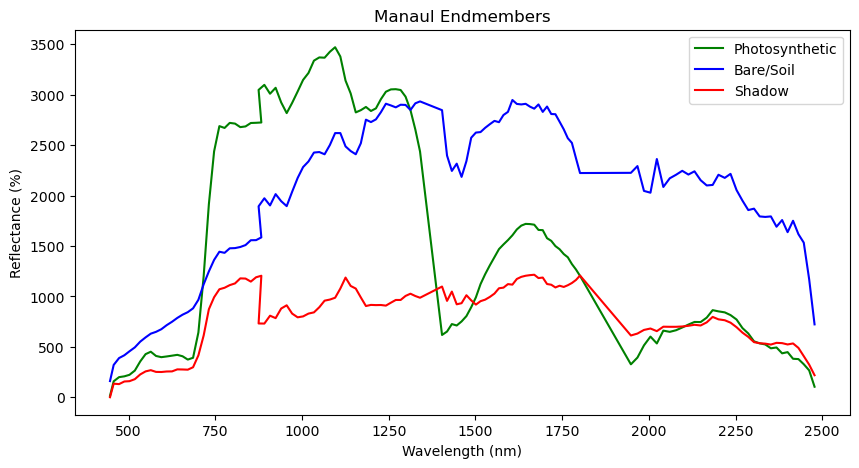

In [23]:
# Plot Endmembers
# Create the matplotlib figure
fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))

ax1.plot(
    hymap_metadata["wavelength"],
    photo_pxl_ppi_vals,
    label="Photosynthetic",
    color="green",
)
ax1.plot(
    hymap_metadata["wavelength"], bare_pxl_ppi_vals, label="Bare/Soil", color="blue"
)
ax1.plot(hymap_metadata["wavelength"], shadow_pxl_ppi_vals, label="Shadow", color="red")
ax1.set_title("Manaul Endmembers")
ax1.set_ylabel("Reflectance (%)")
ax1.set_xlabel("Wavelength (nm)")
ax1.legend()

Image Data Size: 628 x 2702


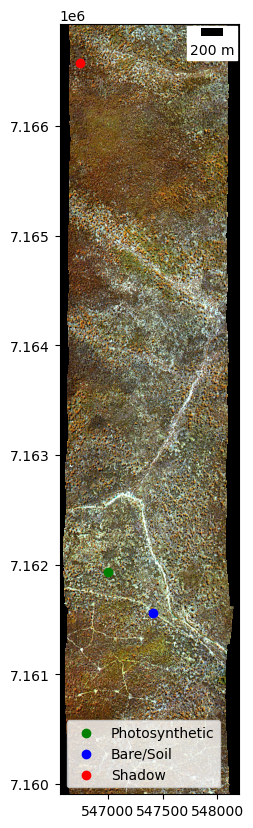

In [24]:
# Plot the Endmember locations on a map
# Create the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 10))

# Plot original Image
# Visualise with bands 32 (NIR), 19 (Red Edge) and 1 (Blue)
rsgislib.tools.mapping.create_raster_img_map(
    ax,
    input_img,
    img_bands=[32, 19, 1],
    img_stch=rsgislib.IMG_STRECTH_CUMULATIVE,
    show_scale_bar=True,
)

ax.scatter(x_coords[0], y_coords[0], label="Photosynthetic", color="green")
ax.scatter(x_coords[1], y_coords[1], label="Bare/Soil", color="blue")
ax.scatter(x_coords[2], y_coords[2], label="Shadow", color="red")
ax.legend()

# 4. Setting Up Spectral Unmixing

For this analysis we will use the endmembers identified through the PPI analysis, but we will also use the spectrally smoothed HyMap output for this analysis.


## 4.1 Create Valid Mask

In [25]:
vld_msk_img = os.path.join(out_dir, "hymap_injune_subset_vld_msk.kea")

rsgislib.imageutils.gen_valid_mask(
    input_img, output_img=vld_msk_img, gdalformat="KEA", no_data_val=0.0
)

# Populate with stats and pyramids as it is a thematic image then use rastergis function.
rsgislib.rastergis.pop_rat_img_stats(
    clumps_img=vld_msk_img, add_clr_tab=True, calc_pyramids=True, ignore_zero=True
)

0) hymap_injune_subset.kea
New image width = 628 height = 2702 bands = 1

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



## 4.2 Smoothing HyMap Spectra

In [26]:
spec_smooth_img = os.path.join(out_dir, "hymap_injune_subset_smoothed.kea")

rsgislib.imageutils.spectral_smoothing(
    input_img,
    valid_msk_img=vld_msk_img,
    valid_msk_val=1,
    output_img=spec_smooth_img,
    win_len=5,
    polyorder=3,
    gdalformat="KEA",
    datatype=rsgislib.TYPE_16INT,
    calc_stats=True,
)

  0%|          | 0/100 [00:00<?, ?it/s]



Calculating Image Pyramids.
































































































































## 4.3 Extract Endmembers

The first step in undertaking a spectral unmixing is to extract the spectra being used for the analysis. RSGISLib provides a function for this as the RSGISLib functions for unmixing require the endmembers to be represented as a text file of a known format.




In [27]:
vec_file = "../data/hymap_ppi_endmembers.geojson"
vec_lyr = "hymap_ppi_endmembers"

endmember_file = os.path.join(out_dir, "hymap_ppi_endmembers.mtxt")

rsgislib.imagecalc.specunmixing.extract_avg_endmembers(
    spec_smooth_img,
    vec_file,
    vec_lyr,
    endmember_file,
    rsgislib.zonalstats.METHOD_POLYCONTAINSPIXELCENTER,
)

Extracting Data for feature 0
Env: [546994.878518, 547002.698278][7161931.81332, 7161937.01103]
Extracting Data for feature 1
Env: [547402.972431, 547413.5][7161560, 7161570.31397]
Extracting Data for feature 2


## 4.4 Plot Endmembers File

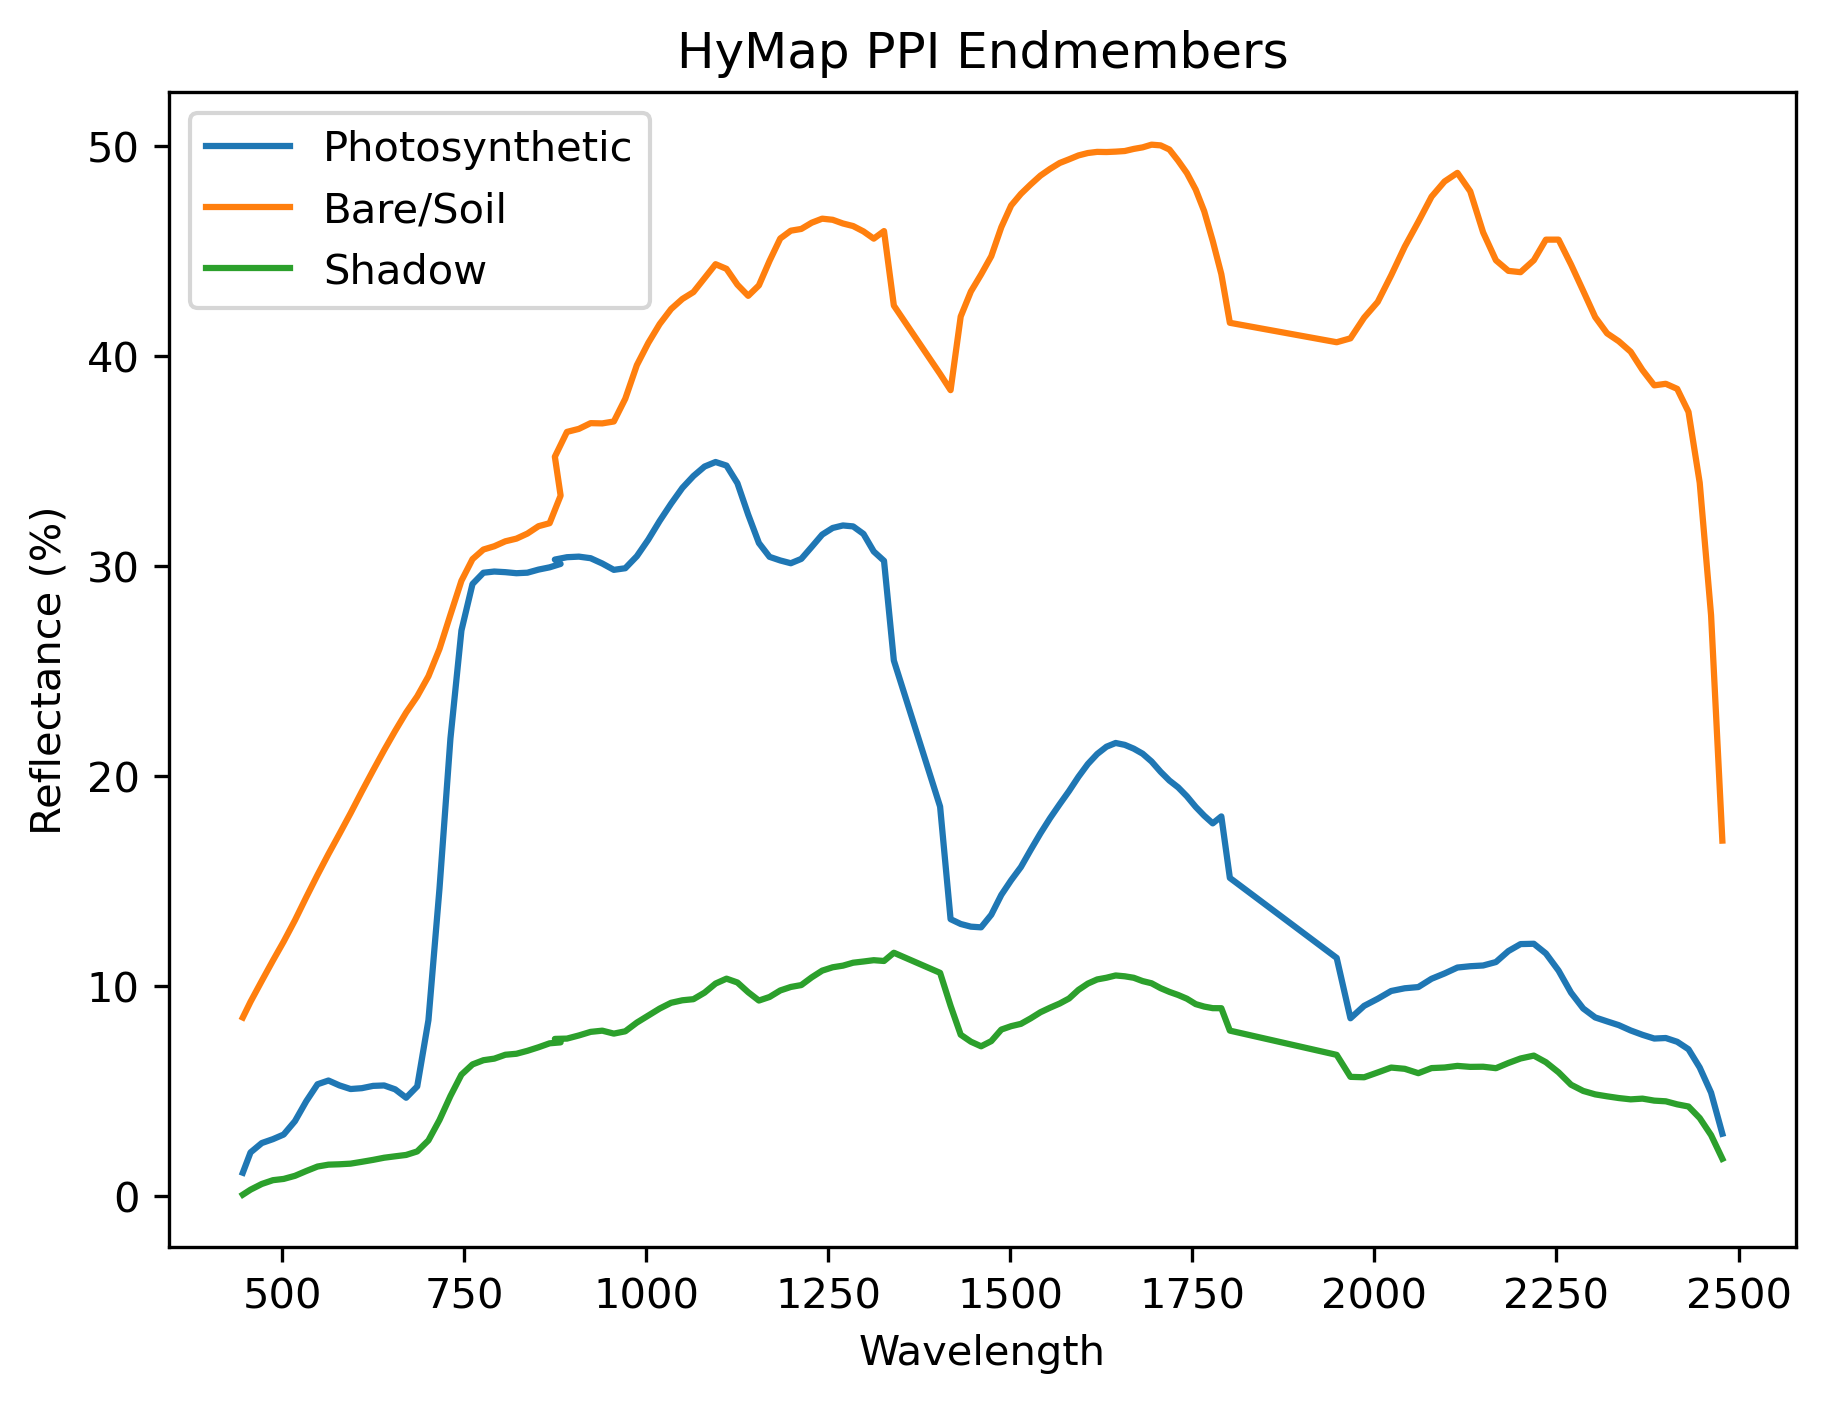

In [28]:
out_plot_file = os.path.join(out_dir, "hymap_ppi_endmembers_plot.png")
endmember_names = ["Photosynthetic", "Bare/Soil", "Shadow"]
rsgislib.imagecalc.specunmixing.plot_endmembers(
    endmember_file,
    endmember_names,
    out_plot_file,
    plot_title="HyMap PPI Endmembers",
    gain=100,
    wavelengths=hymap_metadata["wavelength"],
)

# 5. Simple Unconstrained Unmixing

The simplest and fastest way to perform an unmixing it to run an unconstrained model and then rescale the values to meet the required constrains (i.e., non-negative and sum to 1). This analysis is shown below:

In [29]:
spec_unmix_ucls_img = os.path.join(out_dir, "hymap_injune_subset_ucls.kea")
rsgislib.imagecalc.specunmixing.spec_unmix_spts_ucls(
    spec_smooth_img,
    vld_msk_img,
    1,
    spec_unmix_ucls_img,
    endmember_file,
    gdalformat="KEA",
    gain=1,
    weight=None,
    calc_stats=True,
)

spec_unmix_ucls_scale_img = os.path.join(out_dir, "hymap_injune_subset_ucls_scale.kea")
rsgislib.imagecalc.specunmixing.rescale_unmixing_results(
    spec_unmix_ucls_img, spec_unmix_ucls_scale_img, gdalformat="KEA", calc_stats=True
)

  0%|          | 0/100 [00:00<?, ?it/s]

Env: [546745.32708, 546750.5][7166572.78012, 7166580.62309]


Calculating Image Pyramids.





/Users/pete/miniconda3/envs/osgeo-env-v1/lib/python3.10/site-packages/rsgislib/imagecalc/specunmixing/__init__.py:867: RuntimeWarning: invalid value encountered in divide
  outputs.outimage[idx] = inputs.image[idx] / numpy.sum(inputs.image, axis=0)




Calculating Image Pyramids.





You’ll find two output images:

 * hymap_injune_subset_ucls.kea
 * hymap_injune_subset_ucls_scale.kea

If you open these two images (in TuiView; note you might find it most useful to open them in two geo-linked viewers) you will see that the first image (before rescaling) has quite a lot of fine scale detail while some of this is removed through the rescaling. This is in part as negative values are assigned to 0 during the unmixing. 

Note, from the terminal you can open the two images in separate geo-linked viewer using the following command:

```
tuiview --separate hymap_injune_subset_ucls.kea hymap_injune_subset_ucls_scale.kea
```

Image Data Size: 628 x 2702
Image Data Size: 628 x 2702


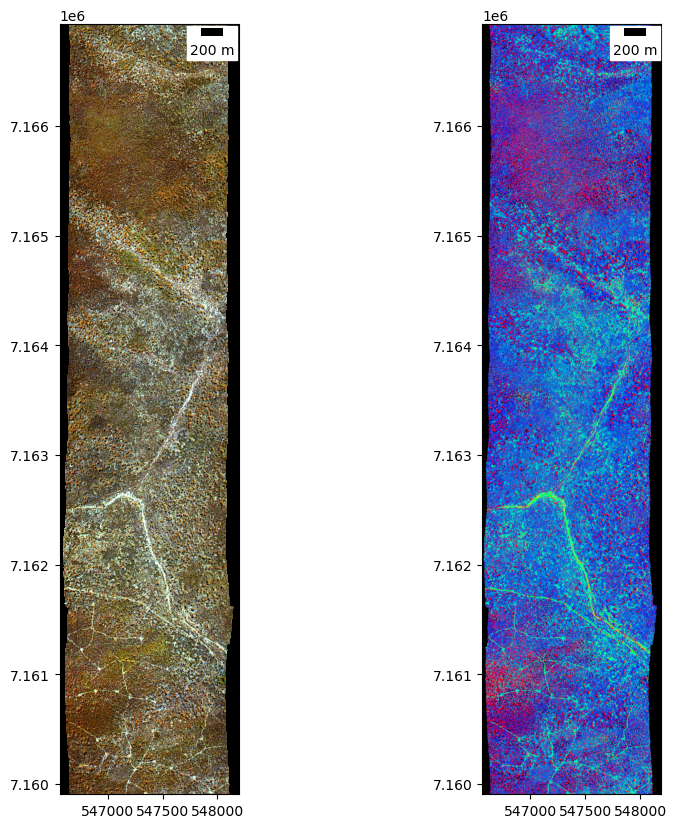

In [44]:
# Create the matplotlib figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

# Plot original Image
# Visualise with bands 32 (NIR), 19 (Red Edge) and 1 (Blue)
rsgislib.tools.mapping.create_raster_img_map(
    ax1,
    input_img,
    img_bands=[32, 19, 1],
    img_stch=rsgislib.IMG_STRECTH_CUMULATIVE,
    show_scale_bar=True,
)

# Plot the spectral unmixing result
rsgislib.tools.mapping.create_raster_img_map(
    ax2,
    spec_unmix_ucls_scale_img,
    img_bands=[1, 2, 3],
    img_stch=rsgislib.IMG_STRETCH_STDEV,
    img_no_data_val=-9999,
    show_scale_bar=True,
)


# 6. Non-Negative Constraint Unmixing

For a fully constrained unmixing the proportions must sum to 1 with no negative values. These conditions can be difficult to meet together but by using non-linear least squares to compute the model we can ensure that the resulting abundances are positive and once rescaled will also sum to 1, meeting both constraints:

In [31]:
spec_unmix_nnls_img = os.path.join(out_dir, "hymap_injune_subset_nnls.kea")
rsgislib.imagecalc.specunmixing.spec_unmix_spts_nnls(
    spec_smooth_img,
    vld_msk_img,
    1,
    spec_unmix_nnls_img,
    endmember_file,
    gdalformat="KEA",
    gain=1,
    weight=None,
    calc_stats=True,
)

spec_unmix_nnls_scale_img = os.path.join(out_dir, "hymap_injune_subset_nnls_scale.kea")
rsgislib.imagecalc.specunmixing.rescale_unmixing_results(
    spec_unmix_nnls_img, spec_unmix_nnls_scale_img, gdalformat="KEA", calc_stats=True
)

  0%|          | 0/100 [00:00<?, ?it/s]



Calculating Image Pyramids.





Calculating Image Pyramids.





Again, view these images within TuiView and look at the pixel values and consider the difference between the two (i.e., the rescaled image sums to 1).


Image Data Size: 628 x 2702
Image Data Size: 628 x 2702


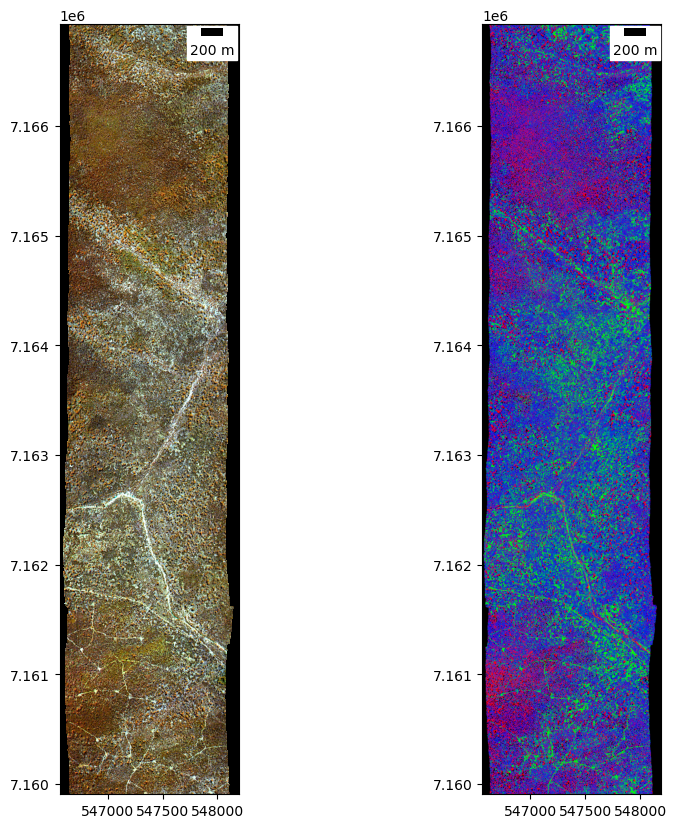

In [45]:
# Create the matplotlib figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

# Plot original Image
# Visualise with bands 32 (NIR), 19 (Red Edge) and 1 (Blue)
rsgislib.tools.mapping.create_raster_img_map(
    ax1,
    input_img,
    img_bands=[32, 19, 1],
    img_stch=rsgislib.IMG_STRECTH_CUMULATIVE,
    show_scale_bar=True,
)

# Plot the spectral unmixing result
rsgislib.tools.mapping.create_raster_img_map(
    ax2,
    spec_unmix_nnls_scale_img,
    img_bands=[1, 2, 3],
    img_stch=rsgislib.IMG_STRETCH_STDEV,
    img_no_data_val=-9999,
    show_scale_bar=True,
)

Alternatively, rather than rescaling the values we can use a weight, as outlined by Scarth et al. (2010), whether a constant weight is added to both the endmembers and image spectra as an extra band and by (experimentally) optimising this value we can constrain the model to sum to 1.

In [33]:
spec_unmix_nnls_wt_img = os.path.join(out_dir, "hymap_injune_subset_nnls_wt.kea")
rsgislib.imagecalc.specunmixing.spec_unmix_spts_nnls(
    spec_smooth_img,
    vld_msk_img,
    1,
    spec_unmix_nnls_wt_img,
    endmember_file,
    gdalformat="KEA",
    gain=10000,
    weight=1000,
    calc_stats=True,
)

  0%|          | 0/100 [00:00<?, ?it/s]



Calculating Image Pyramids.





Now, compare the results of the NNLS rescaled analysis and NNLS weighted analysis:

 * hymap_injune_subset_nnls_scale.kea
 * hymap_injune_subset_nnls_wt.kea

```
tuiview --separate hymap_injune_subset_nnls_scale.kea hymap_injune_subset_nnls_wt.kea
```

Image Data Size: 628 x 2702
Image Data Size: 628 x 2702
Image Data Size: 628 x 2702


Text(0.5, 1.0, 'Weighted')

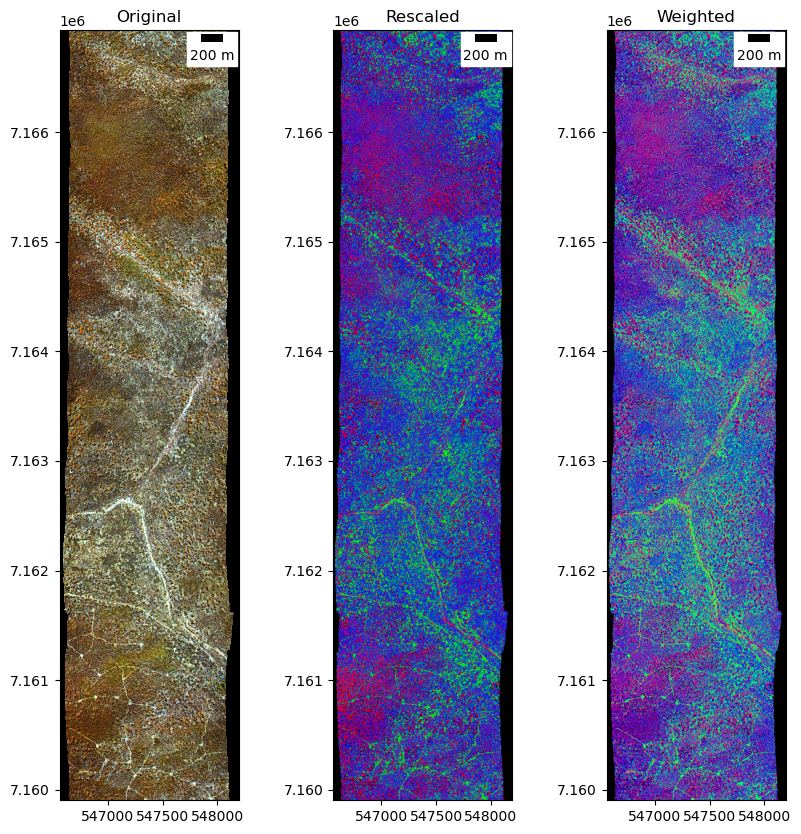

In [46]:
# Create the matplotlib figure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 10))

# Plot original Image
# Visualise with bands 32 (NIR), 19 (Red Edge) and 1 (Blue)
rsgislib.tools.mapping.create_raster_img_map(
    ax1,
    input_img,
    img_bands=[32, 19, 1],
    img_stch=rsgislib.IMG_STRECTH_CUMULATIVE,
    show_scale_bar=True,
)
ax1.set_title("Original")

# Plot the spectral unmixing result
rsgislib.tools.mapping.create_raster_img_map(
    ax2,
    spec_unmix_nnls_scale_img,
    img_bands=[1, 2, 3],
    img_stch=rsgislib.IMG_STRETCH_STDEV,
    img_no_data_val=-9999,
    show_scale_bar=True,
)
ax2.set_title("Rescaled")

# Plot the spectral unmixing result
rsgislib.tools.mapping.create_raster_img_map(
    ax3,
    spec_unmix_nnls_wt_img,
    img_bands=[1, 2, 3],
    img_stch=rsgislib.IMG_STRETCH_STDEV,
    img_no_data_val=-9999,
    show_scale_bar=True,
)
ax3.set_title("Weighted")

If you want to see the effect of the weight try changing this parameter, for example:

 * 10
 * 100
 * 1000
 * 10000
 * 100000
 * 1000000


In [47]:
wts = [10, 100, 1000, 10000, 100000, 1000000]
for wt in wts:
    spec_unmix_nnls_wt_img = os.path.join(
        out_dir, "hymap_injune_subset_nnls_wt_{}.kea".format(wt)
    )
    rsgislib.imagecalc.specunmixing.spec_unmix_spts_nnls(
        spec_smooth_img,
        vld_msk_img,
        1,
        spec_unmix_nnls_wt_img,
        endmember_file,
        gdalformat="KEA",
        gain=1,
        weight=wt,
        calc_stats=True,
    )

  0%|          | 0/100 [00:00<?, ?it/s]



Calculating Image Pyramids.





  0%|          | 0/100 [00:00<?, ?it/s]



Calculating Image Pyramids.





  0%|          | 0/100 [00:00<?, ?it/s]



Calculating Image Pyramids.





  0%|          | 0/100 [00:00<?, ?it/s]



Calculating Image Pyramids.





  0%|          | 0/100 [00:00<?, ?it/s]



Calculating Image Pyramids.





  0%|          | 0/100 [00:00<?, ?it/s]



Calculating Image Pyramids.





Image Data Size: 628 x 2702
Image Data Size: 628 x 2702
Image Data Size: 628 x 2702
Image Data Size: 628 x 2702
Image Data Size: 628 x 2702
Image Data Size: 628 x 2702


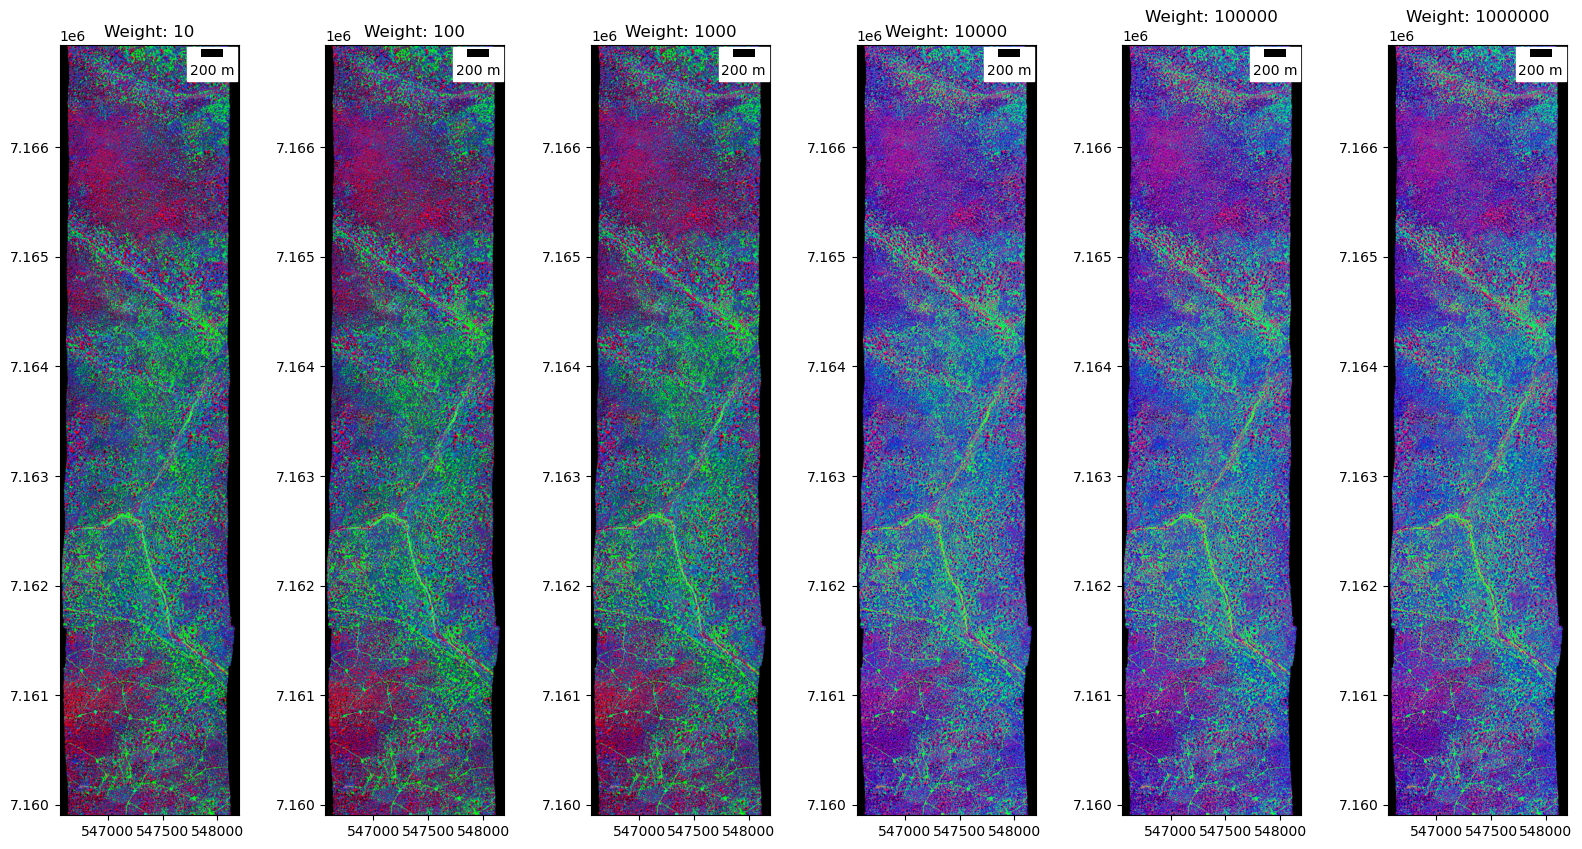

In [48]:
# Create the matplotlib figure
fig, axs = plt.subplots(1, 6, figsize=(20, 10))

for wt, ax in zip(wts, axs):
    spec_unmix_nnls_wt_img = os.path.join(
        out_dir, "hymap_injune_subset_nnls_wt_{}.kea".format(wt)
    )
    
    # Plot the spectral unmixing result
    rsgislib.tools.mapping.create_raster_img_map(
        ax,
        spec_unmix_nnls_wt_img,
        img_bands=[1, 2, 3],
        img_stch=rsgislib.IMG_STRETCH_STDEV,
        img_no_data_val=-9999,
        show_scale_bar=True,
    )
    ax.set_title("Weight: {}".format(wt))

Note. the weight is relative to the scale of the image values so note, the gain value was change (to 1) to help illustrate the effect of the weight parameter. Given the HyMap data has been multiplied by 10,000 then a gain of 10,000, as used earlier and is the correct value to use as it rescales the data to a range of 0 – 1 for the unmixing. Hence you get a different result for the weight 1000. 

You can easily open all the images in different TuiView windows using the following command:

tuiview --separate hymap_injune_subset_nnls_wt_*.kea


# 7. Fully Constrained Unmixing

As you’ll have seen, using the weighted NNLS result directly produces a fully constrained linear unmixing of the data but there are other approaches, which use different optimisation algorithms and doesn’t require the weight parameter to be optimised. However, this can take much longer to compute (note, this code will be about 10 mins). 

In [ ]:
spec_unmix_fcls_img = os.path.join(out_dir, "hymap_injune_subset_fcls.kea")
rsgislib.imagecalc.specunmixing.spec_unmix_spts_fcls(
    spec_smooth_img,
    vld_msk_img,
    1,
    spec_unmix_fcls_img,
    endmember_file,
    gdalformat="KEA",
    gain=10000,
    calc_stats=True,
)

  0%|          | 0/100 [00:00<?, ?it/s]

Once, you have this output compare it to the NNLS weighted output. How much difference do you notice? Is there much difference in the abundances generated?

 * hymap_injune_subset_fcls.kea
 * hymap_injune_subset_nnls_wt.kea


In [ ]:
# Create the matplotlib figure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 10))

# Plot original Image
# Visualise with bands 32 (NIR), 19 (Red Edge) and 1 (Blue)
rsgislib.tools.mapping.create_raster_img_map(
    ax1,
    input_img,
    img_bands=[32, 19, 1],
    img_stch=rsgislib.IMG_STRECTH_CUMULATIVE,
    show_scale_bar=True,
)

# Plot the spectral unmixing result
rsgislib.tools.mapping.create_raster_img_map(
    ax2,
    spec_unmix_fcls_img,
    img_bands=[1, 2, 3],
    img_stch=rsgislib.IMG_STRETCH_STDEV,
    img_no_data_val=-9999,
    show_scale_bar=True,
)
ax2.set_title("FCLS")

# Plot the spectral unmixing result
spec_unmix_nnls_wt_img = os.path.join(out_dir, "hymap_injune_subset_nnls_wt.kea")
rsgislib.tools.mapping.create_raster_img_map(
    ax3,
    spec_unmix_nnls_wt_img,
    img_bands=[1, 2, 3],
    img_stch=rsgislib.IMG_STRETCH_STDEV,
    img_no_data_val=-9999,
    show_scale_bar=True,
)
ax3.set_title("NNLS")

# 8. Recomputing a reflectance image from the endmembers and abundances

In [ ]:
pred_refl_img = os.path.join(out_dir, "hymap_injune_subset_pred_refl.kea")
rsgislib.imagecalc.specunmixing.predict_refl_linear_unmixing(
    spec_unmix_fcls_img,
    endmember_file,
    pred_refl_img,
    gdalformat="KEA",
    calc_stats=True,
)

Open the resulting image and what do you noticed when compared to the original image?

In [ ]:
# Create the matplotlib figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

# Plot original Image
# Visualise with bands 32 (NIR), 19 (Red Edge) and 1 (Blue)
rsgislib.tools.mapping.create_raster_img_map(
    ax1,
    input_img,
    img_bands=[32, 19, 1],
    img_stch=rsgislib.IMG_STRECTH_CUMULATIVE,
    show_scale_bar=True,
)
ax1.set_title("Original")

# Plot predicted Image
# Visualise with bands 32 (NIR), 19 (Red Edge) and 1 (Blue)
rsgislib.tools.mapping.create_raster_img_map(
    ax2,
    pred_refl_img,
    img_bands=[32, 19, 1],
    img_stch=rsgislib.IMG_STRECTH_CUMULATIVE,
    show_scale_bar=True,
)
ax2.set_title("Predicted")

# 9. Calculating Error to Original

If we can reproduce something similar to the original image, then we can calculate the error between the original image and the predicted. This can be useful for comparing different approaches and endmembers providing a numeric way of comparing how well an unmixing and endmembers can represent the original image. The following scripts calculating the root square mean error (RMSE) and the residual on a per-pixel basis:

In [ ]:
unmix_rmse_img = os.path.join(out_dir, "hymap_injune_subset_unmix_rmse.kea")
rsgislib.imagecalc.specunmixing.calc_unmixing_rmse_residual_err(
    input_img,
    spec_unmix_fcls_img,
    endmember_file,
    unmix_rmse_img,
    gdalformat="KEA",
    calc_stats=True,
)

In [ ]:
# Create the matplotlib figure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 10))

# Plot original Image
# Visualise with bands 32 (NIR), 19 (Red Edge) and 1 (Blue)
rsgislib.tools.mapping.create_raster_img_map(
    ax1,
    input_img,
    img_bands=[32, 19, 1],
    img_stch=rsgislib.IMG_STRECTH_CUMULATIVE,
    show_scale_bar=True,
)
ax1.set_title("Original")

# Plot the spectral unmixing result
rsgislib.tools.mapping.create_raster_img_map(
    ax2,
    spec_unmix_fcls_img,
    img_bands=[1, 2, 3],
    img_stch=rsgislib.IMG_STRETCH_STDEV,
    img_no_data_val=-9999,
    show_scale_bar=True,
)
ax2.set_title("FCLS")

rsgislib.tools.mapping.create_raster_cmap_img_map(
    ax3,
    unmix_rmse_img,
    img_band=1,
    cmap_name="viridis",
    norm_img_vals=True,
    show_scale_bar=True,
)
ax3.set_title("RMSE")

# 10. Summary

Most of the time we are not undertaking hyperspectral data analysis, however that does not mean that these methods are not relevant for other some multispectral dataset or problems. Therefore, somethings to take away from this analysis:

 * Spectral unmixing can be a powerful technical and work really well on multispectral data. For example, the analysis of Ettritch et al., (2018) using landsat as covered in the lecture.
 * Image classification is clearly a massive topic and is a common analysis which is performed on hyperspectral data. We haven’t covered it here as you have already done a lot of image classification work. Machine learning approaches of classification are commonly applied to hyperspectral data but do consider the high amount of correlation between your image bands. There are also approaches, as covered in the lecture, specifically tailored to hyperspectral data analysis such as spectral angle mapper and spectral correlation mapper.
 * PCA and other dimensionality reduction methods can be applied in a wide range of applications. For example, reducing and combining variables which are highly correlated from a classification or regression analysis, such as habitat suitability modelling.
